In [3]:
# ==================================================================================
# loan_default_project_complete.py  --  single-cell / single-file pipeline
# ==================================================================================
# Usage in notebook (Kaggle/Colab/Jupyter):
#   1) Place loan_data.csv in /kaggle/input/<folder>/ or upload to working dir.
#   2) Paste this full cell into the notebook and run.
#   3) If you want to change behavior, edit the variables under "USER CONFIG" below.
# ==================================================================================

import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# USER CONFIG (edit if needed)
# --------------------------
# If you know the path to the CSV file, set CSV_PATH to that exact path.
# Otherwise set CSV_PATH = None and the script will attempt to auto-detect.
CSV_PATH = "/kaggle/input/dataset/loan_data.csv"
# Default output directory where artifacts will be saved
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Toggle expensive operations
DO_GRIDSEARCH = False    # set True to run GridSearchCV (may be slow on large data)
SAMPLE_FOR_SEARCH = 10000  # if doing gridsearch, sample this many rows for the search (set None for full)
DO_CALIBRATE = False     # set True to calibrate probabilities
DO_SHAP = False          # set True to attempt SHAP explanations (requires 'shap' package)
N_JOBS = -1              # for GridSearchCV parallelism (-1 = use all cores)

# --------------------------
# Imports used by pipeline
# --------------------------
import json
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

# --------------------------
# Utilities
# --------------------------
def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)

def save_fig(fig, path):
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)

def safe_roc_auc(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except Exception:
        return np.nan

def find_csv_in_path(path_like):
    """
    Given a Path or string:
      - if it's a file and endswith .csv -> return it
      - if it's a dir -> return preferred 'loan_data.csv' if present else first .csv found
      - if None -> search common Kaggle input dirs for csv
    """
    p = Path(path_like) if path_like is not None else None

    if p is not None and p.exists():
        if p.is_file():
            if p.suffix.lower() == ".csv":
                return p
            else:
                raise FileNotFoundError(f"Provided path is a file but not CSV: {p}")
        if p.is_dir():
            csvs = sorted([f for f in p.iterdir() if f.suffix.lower() == ".csv"])
            if not csvs:
                raise FileNotFoundError(f"No CSV files found in directory: {p}")
            pref = p / "loan_data.csv"
            if pref.exists():
                return pref
            return csvs[0]
    # If no explicit path provided, try to auto-discover in common places (Kaggle)
    # Search /kaggle/input for CSVs
    kaggle_input = Path("/kaggle/input")
    if kaggle_input.exists():
        # search recursively but prefer loan_data.csv
        all_csvs = list(kaggle_input.rglob("*.csv"))
        if not all_csvs:
            raise FileNotFoundError("Could not find any CSV files under /kaggle/input. Please set CSV_PATH.")
        # prefer file named loan_data.csv
        for f in all_csvs:
            if f.name == "loan_data.csv":
                return f
        # else return first
        return all_csvs[0]
    raise FileNotFoundError("No CSV path provided and /kaggle/input not available. Please set CSV_PATH to the CSV file.")

# --------------------------
# Main pipeline
# --------------------------
def run_pipeline(data_file, output_dir,
                 do_gridsearch=False, sample_for_search=10000,
                 do_calibrate=False, do_shap=False, n_jobs=-1):
    data_file = Path(data_file)
    output_dir = Path(output_dir)
    ensure_dir(output_dir)

    # Load
    print("Loading data from:", data_file)
    df = pd.read_csv(data_file)
    print("Data shape:", df.shape)
    display_head = False
    try:
        # display first few rows if Jupyter environment
        from IPython.display import display
        display(df.head())
        display_head = True
    except Exception:
        pass

    # Validate target
    target = "loan_paid_back"
    if target not in df.columns:
        raise RuntimeError(f"Target column '{target}' not found. Columns: {df.columns.tolist()}")

    # Basic EDA summary
    print("\nTarget distribution:")
    print(df[target].value_counts(dropna=False))
    print(f"Positive rate (paid back == 1): {df[target].mean():.4f}")
    eda = {
        "rows": int(df.shape[0]),
        "cols": int(df.shape[1]),
        "target_counts": df[target].value_counts().to_dict(),
        "target_rate": float(df[target].mean())
    }
    with open(output_dir / "eda_summary.json", "w") as f:
        json.dump(eda, f, indent=2)

    # Drop id if present
    if "id" in df.columns:
        df = df.drop(columns=["id"])

    # Ensure target is int
    df[target] = df[target].astype(int)

    # Features / target split
    X = df.drop(columns=[target])
    y = df[target]

    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    print("\nNumeric columns:", numeric_cols)
    print("Categorical columns:", categorical_cols)

    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

    # Preprocessing
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ], remainder="drop")

    # Model & pipeline
    base_model = HistGradientBoostingClassifier(random_state=42,
                                                max_iter=200,
                                                max_leaf_nodes=31,
                                                learning_rate=0.1)
    pipeline = Pipeline([
        ("preproc", preprocessor),
        ("clf", base_model)
    ])

    # GridSearch option
    best_model = None
    if do_gridsearch:
        print("\n=== GridSearchCV chosen (this may take time) ===")
        param_grid = {
            "clf__max_iter": [100, 200],
            "clf__max_leaf_nodes": [31, 63],
            "clf__learning_rate": [0.05, 0.1]
        }
        # Optionally sample for search
        if sample_for_search is not None and sample_for_search > 0:
            sample_n = min(sample_for_search, X_train.shape[0])
            print(f"Sampling {sample_n} rows for grid search (stratified).")
            X_samp, _, y_samp, _ = train_test_split(X_train, y_train, train_size=sample_n, stratify=y_train, random_state=42)
            X_search, y_search = X_samp, y_samp
        else:
            X_search, y_search = X_train, y_train

        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
        grid = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=cv, n_jobs=n_jobs, verbose=1)
        grid.fit(X_search, y_search)
        print("Grid best params:", grid.best_params_)
        print("Grid best CV AUC:", grid.best_score_)
        best_model = grid.best_estimator_
        pd.DataFrame(grid.cv_results_).to_csv(output_dir / "gridsearch_results.csv", index=False)
        joblib.dump(grid, output_dir / "gridsearch_object.joblib")
    else:
        print("\nFitting pipeline without GridSearch...")
        pipeline.fit(X_train, y_train)
        best_model = pipeline

    # Save pipeline
    joblib.dump(best_model, output_dir / "final_model_pipeline.joblib")
    print("Saved model pipeline to:", output_dir / "final_model_pipeline.joblib")

    # Test evaluation
    print("\nEvaluating on test set...")
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_proba = best_model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        except Exception:
            y_proba = best_model.predict(X_test)

    test_auc = safe_roc_auc(y_test, y_proba)
    print(f"Test ROC AUC: {test_auc:.6f}")


    # ROC plot
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc_val = auc(fpr, tpr)
    fig = plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
    plt.plot([0,1], [0,1], "--", linewidth=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.legend(loc="lower right"); plt.grid(True)
    save_fig(fig, output_dir / "roc_curve_test.png")
    print("Saved ROC plot to:", output_dir / "roc_curve_test.png")

    # Save test predictions with metadata
    X_test_out = X_test.copy().reset_index(drop=True)
    X_test_out["y_true"] = y_test.reset_index(drop=True)
    X_test_out["y_proba"] = y_proba
    X_test_out.to_csv(output_dir / "test_predictions.csv", index=False)
    print("Saved test predictions to:", output_dir / "test_predictions.csv")

    # Subgroup analysis
    print("\nPerforming subgroup AUC analysis...")

    def subgroup_auc_table(df_meta, group_col, min_n=1):
        groups = []
        for name, g in df_meta.groupby(group_col):
            n = len(g)
            if n < min_n:
                groups.append((name, n, np.nan))
                continue
            if g["y_true"].nunique() < 2:
                groups.append((name, n, np.nan))
                continue
            try:
                a = roc_auc_score(g["y_true"], g["y_proba"])
            except Exception:
                a = np.nan
            groups.append((name, n, a))
        out = pd.DataFrame(groups, columns=[group_col, "n", "auc"]).sort_values("auc", ascending=False)
        return out

    # education_level
    if "education_level" in X_test_out.columns:
        edu_table = subgroup_auc_table(X_test_out, "education_level", min_n=5)
        edu_table.to_csv(output_dir / "auc_by_education_level.csv", index=False)
        print("AUC by education_level saved to:", output_dir / "auc_by_education_level.csv")
        print(edu_table)
    else:
        print("Column 'education_level' not present; skipping that subgroup analysis.")

    # loan_purpose
    if "loan_purpose" in X_test_out.columns:
        purpose_table = subgroup_auc_table(X_test_out, "loan_purpose", min_n=5)
        purpose_table.to_csv(output_dir / "auc_by_loan_purpose.csv", index=False)
        print("AUC by loan_purpose saved to:", output_dir / "auc_by_loan_purpose.csv")
        # top3 & bottom3 (n >= 10 for stability)
        stable = purpose_table[purpose_table["n"] >= 10].copy()
        top3 = stable.sort_values("auc", ascending=False).head(3)
        bottom3 = stable.sort_values("auc", ascending=True).head(3)
        top3.to_csv(output_dir / "top3_purposes.csv", index=False)
        bottom3.to_csv(output_dir / "bottom3_purposes.csv", index=False)
        print("\nTop 3 loan purposes by AUC (n>=10):")
        print(top3)
        print("\nBottom 3 loan purposes by AUC (n>=10):")
        print(bottom3)
    else:
        print("Column 'loan_purpose' not present; skipping that subgroup analysis.")

    # Calibration (optional)
    if do_calibrate:
        print("\nCalibrating probabilities (this may take extra time)...")
        X_tr_sub, X_hold, y_tr_sub, y_hold = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)
        try:
            calibrator = CalibratedClassifierCV(base_estimator=best_model, method="sigmoid", cv="prefit")
            calibrator.fit(X_hold, y_hold)
        except Exception:
            print("Prefit calibration failed; refitting a fresh pipeline for calibration.")
            fresh_pipeline = Pipeline([("preproc", preprocessor), ("clf", HistGradientBoostingClassifier(random_state=42,
                                                                                                        max_iter=200,
                                                                                                        max_leaf_nodes=31,
                                                                                                        learning_rate=0.1))])
            fresh_pipeline.fit(X_tr_sub, y_tr_sub)
            calibrator = CalibratedClassifierCV(base_estimator=fresh_pipeline, method="sigmoid", cv="prefit")
            calibrator.fit(X_hold, y_hold)
        y_proba_cal = calibrator.predict_proba(X_test)[:, 1]
        calibrated_auc = safe_roc_auc(y_test, y_proba_cal)
        print("Calibrated Test AUC:", calibrated_auc)
        fpr_c, tpr_c, _ = roc_curve(y_test, y_proba_cal)
        fig2 = plt.figure(figsize=(6,5))
        plt.plot(fpr_c, tpr_c, label=f"AUC (calibrated) = {calibrated_auc:.4f}")
        plt.plot([0,1], [0,1], '--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Calibrated ROC Curve (Test)")
        plt.legend(loc="lower right"); plt.grid(True)
        save_fig(fig2, output_dir / "roc_curve_test_calibrated.png")
        joblib.dump(calibrator, output_dir / "calibrated_model.joblib")
        X_test_out["y_proba_calibrated"] = y_proba_cal
        X_test_out.to_csv(output_dir / "test_predictions_with_calibrated.csv", index=False)
        print("Saved calibrated predictions and model.")

    # SHAP explanations (optional)
    if do_shap:
        print("\nAttempting SHAP explanations (requires 'shap' package)...")
        try:
            import shap
            sample_n = min(500, X_test.shape[0])
            shap_sample = X_test.sample(n=sample_n, random_state=42)
            preproc = best_model.named_steps["preproc"] if isinstance(best_model, Pipeline) else None
            clf = best_model.named_steps["clf"] if isinstance(best_model, Pipeline) else best_model
            if preproc is not None:
                shap_X = preproc.transform(shap_sample)
                try:
                    cat = preproc.named_transformers_["cat"]
                    ohe = cat.named_steps["onehot"]
                    ohe_names = ohe.get_feature_names_out(categorical_cols)
                    feature_names = numeric_cols + list(ohe_names)
                except Exception:
                    feature_names = [f"f{i}" for i in range(shap_X.shape[1])]
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(shap_X)
                shap.summary_plot(shap_values, shap_X, feature_names=feature_names, show=False)
                plt.savefig(output_dir / "shap_summary.png", bbox_inches="tight", dpi=150)
                plt.close('all')
                print("Saved SHAP summary to:", output_dir / "shap_summary.png")
            else:
                print("Preprocessor not in pipeline; cannot run SHAP")
        except Exception as e:
            print("SHAP failed or not installed:", e)
            print("Install shap with: pip install shap")

    # Save run summary
    summary = {
        "test_auc": float(test_auc) if not np.isnan(test_auc) else None,
        "roc_plot": str(output_dir / "roc_curve_test.png"),
        "auc_by_education_level": str(output_dir / "auc_by_education_level.csv") if "education_level" in X_test_out.columns else None,
        "auc_by_loan_purpose": str(output_dir / "auc_by_loan_purpose.csv") if "loan_purpose" in X_test_out.columns else None
    }
    with open(output_dir / "run_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print("\n=== Pipeline complete. Artifacts written to:", output_dir.resolve(), "===\n")
    for p in sorted(output_dir.iterdir()):
        print(" -", p.name)

# --------------------------
# Auto-detect CSV file to use
# --------------------------
try:
    data_file = find_csv_in_path(CSV_PATH)
    print("Using data file:", data_file)
except Exception as e:
    raise RuntimeError(f"Could not auto-detect CSV file. Error: {e}")

# --------------------------
# Run pipeline with chosen config
# --------------------------
run_pipeline(
    data_file,
    OUTPUT_DIR,
    do_gridsearch=DO_GRIDSEARCH,
    sample_for_search=SAMPLE_FOR_SEARCH,
    do_calibrate=DO_CALIBRATE,
    do_shap=DO_SHAP,
    n_jobs=N_JOBS
)

Using data file: /kaggle/input/dataset/loan_data.csv
Loading data from: /kaggle/input/dataset/loan_data.csv
Data shape: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1



Target distribution:
loan_paid_back
1    214068
0     54046
Name: count, dtype: int64
Positive rate (paid back == 1): 0.7984

Numeric columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

Train: (201085, 11), Test: (67029, 11)

Fitting pipeline without GridSearch...
Saved model pipeline to: outputs/final_model_pipeline.joblib

Evaluating on test set...
Test ROC AUC: 0.918891
Saved ROC plot to: outputs/roc_curve_test.png
Saved test predictions to: outputs/test_predictions.csv

Performing subgroup AUC analysis...
AUC by education_level saved to: outputs/auc_by_education_level.csv
  education_level      n       auc
3           Other   2887  0.924529
0      Bachelor's  31584  0.920550
2        Master's  10487  0.917880
1     High School  20822  0.916846
4             PhD   1249  0.896463
AUC by loan_purpose saved to: outp

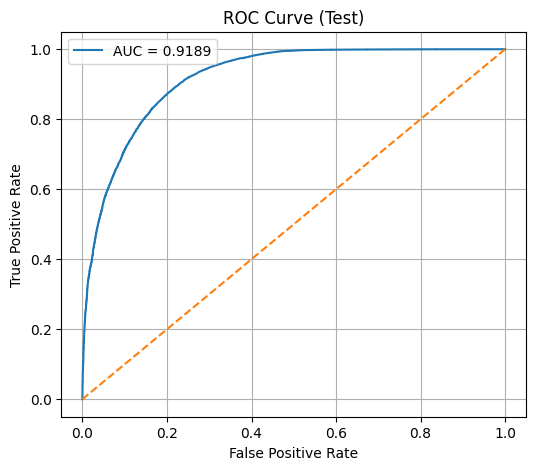

In [4]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("outputs/test_predictions.csv")
y_true = df["y_true"]
y_proba = df["y_proba"]

fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.grid(True)
plt.show()